Current Date and Time: 2024-12-03 01:08:56

Latest Inflation Rates:
USA: 2.6%
Europe: 2.3%
Asia: 1.5%
Middle East: 3.0%
North America: 2.5%
China: 0.3%
Japan: 2.3%



Do you want to get data for a specific stock, the market status, compare two items, evaluate risk, view a prediction, calculate VaR, evaluate option pricing, or use the Kelly criterion? (stock/market/compare/risk/predict/var/option/kelly):  predict
Enter stock symbol or index name for prediction (e.g., AAPL or S&P 500):  NVDA
Enter range for prediction (1y, 6m, 3m, 1m, 1w, 24h):  1y


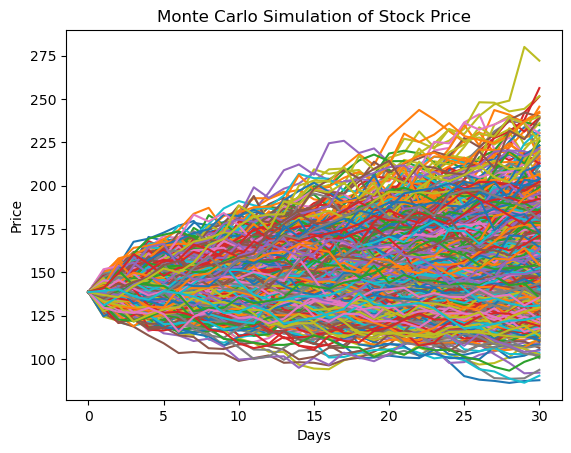

Prediction for NVDA over 1y: 150.34 expected closing price


In [3]:
import yfinance as yf
import pandas as pd
import datetime
import requests
from bs4 import BeautifulSoup
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import random


from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import norm
from scipy.optimize import minimize
from scipy.stats import binom


import matplotlib.pyplot as plt


def get_current_datetime():
    now = datetime.datetime.now()
    return now.strftime("%Y-%m-%d %H:%M:%S")

def get_inflation_rate(country):
    # Placeholder function to simulate fetching inflation rates
    # Replace with actual data retrieval logic
    inflation_data = {
        'USA': 2.6,
        'Europe': 2.3,
        'Asia': 1.5,
        'Middle East': 3.0,
        'North America': 2.5,
        'China': 0.3,
        'Japan': 2.3
    }
    return inflation_data.get(country, "Data not available")

def display_inflation_rates():
    regions = ['USA', 'Europe', 'Asia', 'Middle East', 'North America', 'China', 'Japan']
    print("\nLatest Inflation Rates:")
    for region in regions:
        rate = get_inflation_rate(region)
        print(f"{region}: {rate}%")

def get_stock_data(symbol, range_period):
    stock = yf.Ticker(symbol)

    
    if range_period == "1y":
        period = "1y"
    elif range_period == "6m":
        period = "6mo"
    elif range_period == "3m":
        period = "3mo"
    elif range_period == "1m":
        period = "1mo"
    elif range_period == "1w":
        period = "7d"
    elif range_period == "24h":
        period = "1d"
    else:
        raise ValueError("Invalid range. Available options: 1y, 6m, 3m, 1m, 1w, 24h")

    
    data = stock.history(period=period)

    if not data.empty:
        stock_data = data[['Open', 'High', 'Low', 'Close', 'Volume']]
        return stock_data
    else:
        return {"error": "Failed to retrieve data or no data available."}

def get_market_status(index_name):
    
    tickers = []  
        
    data = yf.download(tickers, period='1d', group_by='ticker')
    
    
    market_status = []
    for ticker in tickers:
        if ticker in data:
            df = data[ticker]
            if not df.empty:
                open_price = df['Open'].iloc[0]
                close_price = df['Close'].iloc[0]
                change = ((close_price - open_price) / open_price) * 100
                market_status.append({
                    'Ticker': ticker,
                    'Open': open_price,
                    'Close': close_price,
                    'Change (%)': change
                })
    
    
    market_status_df = pd.DataFrame(market_status)
    return market_status_df

def compare_stocks_or_indices(item1, item2, range_period):
    data1 = get_stock_data(item1, range_period) if item1.isalpha() else get_market_status(item1)
    data2 = get_stock_data(item2, range_period) if item2.isalpha() else get_market_status(item2)
    
    if isinstance(data1, dict) or isinstance(data2, dict):
        print("Error retrieving data for one or both items.")
        return
    
    
    print("\nComparison between {} and {}:".format(item1, item2))
    print("Data for {}: \n{}".format(item1, data1))
    print("\nData for {}: \n{}".format(item2, data2))
    
    mean_return_1 = data1['Close'].pct_change().mean() if isinstance(data1, pd.DataFrame) else 0
    mean_return_2 = data2['Close'].pct_change().mean() if isinstance(data2, pd.DataFrame) else 0
    if mean_return_1 > mean_return_2:
        print(f"Based on mean returns, {item1} is a better investment option compared to {item2}.")
    elif mean_return_1 < mean_return_2:
        print(f"Based on mean returns, {item2} is a better investment option compared to {item1}.")
    else:
        print(f"Both {item1} and {item2} have similar mean returns.")

def calculate_risk(stock_data):
    
    if isinstance(stock_data, pd.DataFrame):
        if 'Close' in stock_data.columns:
            close_prices = stock_data['Close']
            risk = close_prices.pct_change().std() * 100  # Risk as standard deviation percentage
            return risk
    return None

def evaluate_risk(symbol, range_period):
    stock_data = get_stock_data(symbol, range_period)
    if isinstance(stock_data, dict) and "error" in stock_data:
        print(stock_data["error"])
    else:
        risk = calculate_risk(stock_data)
        if risk is not None:
            print(f"Risk evaluation for {symbol} over the period {range_period}: {risk:.2f}% volatility")
        else:
            print("Unable to calculate risk.")

def value_at_risk(stock_data, confidence_level=0.95):
    
    close_prices = stock_data['Close']
    returns = close_prices.pct_change().dropna()
    var = np.percentile(returns, (1 - confidence_level) * 100) * close_prices.iloc[-1]
    return var

def evaluate_var(symbol, range_period):
    stock_data = get_stock_data(symbol, range_period)
    if isinstance(stock_data, dict) and "error" in stock_data:
        print(stock_data["error"])
    else:
        var = value_at_risk(stock_data)
        print(f"Value at Risk (VaR) for {symbol} over the period {range_period}: ${var:.2f}")

def portfolio_optimization(returns):
    
    num_assets = returns.shape[1]
    args = (returns.mean(), returns.cov())
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for asset in range(num_assets))
    result = minimize(portfolio_volatility, num_assets * [1. / num_assets,], args=args, bounds=bounds, constraints=constraints)
    return result.x

def portfolio_volatility(weights, mean_returns, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

def black_scholes_option_pricing(S, K, T, r, sigma, option_type="call"):
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == "call":
        price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == "put":
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("Invalid option type. Choose 'call' or 'put'")
    return price

def evaluate_option_price():
    S = float(input("Enter current stock price: "))
    K = float(input("Enter strike price: "))
    T = float(input("Enter time to maturity in years: "))
    r = float(input("Enter risk-free interest rate (as a decimal): "))
    sigma = float(input("Enter volatility (as a decimal): "))
    option_type = input("Enter option type ('call' or 'put'): ")
    price = black_scholes_option_pricing(S, K, T, r, sigma, option_type)
    print(f"The price of the {option_type} option is: ${price:.2f}")

def kelly_criterion(expected_return, risk_free_rate, variance):
    
    return (expected_return - risk_free_rate) / variance

def evaluate_kelly_criterion():
    expected_return = float(input("Enter expected return (as a decimal): "))
    risk_free_rate = float(input("Enter risk-free rate (as a decimal): "))
    variance = float(input("Enter variance of the return (as a decimal): "))
    kelly_fraction = kelly_criterion(expected_return, risk_free_rate, variance)
    print(f"The optimal fraction of your capital to invest according to the Kelly criterion is: {kelly_fraction:.2f}")

def moving_average_prediction(stock_data, window=10):
    
    stock_data['MA'] = stock_data['Close'].rolling(window=window).mean()
    return stock_data['MA'].iloc[-1]

def monte_carlo_simulation(stock_data, num_simulations=1000, num_days=30):
   
    close_prices = stock_data['Close']
    daily_return = close_prices.pct_change().dropna()
    mean_return = daily_return.mean()
    volatility = daily_return.std()
    
    simulation_results = []
    last_price = close_prices.iloc[-1]
    
    for _ in range(num_simulations):
        price_series = [last_price]
        for _ in range(num_days):
            price = price_series[-1] * (1 + np.random.normal(mean_return, volatility))
            price_series.append(price)
        simulation_results.append(price_series)
    
    for simulation in simulation_results:
        plt.plot(simulation)
    plt.xlabel('Days')
    plt.ylabel('Price')
    plt.title('Monte Carlo Simulation of Stock Price')
    plt.show()
    
    return np.mean([simulation[-1] for simulation in simulation_results])

def predict_market(symbol, range_period):
    stock_data = get_stock_data(symbol, range_period)
    if isinstance(stock_data, dict) and "error" in stock_data:
        return "Error in fetching stock data"
    

    ma_prediction = moving_average_prediction(stock_data)
    monte_carlo_prediction = monte_carlo_simulation(stock_data)
    
    prediction_result = (ma_prediction + monte_carlo_prediction) / 2
    return prediction_result

def evaluate_prediction():
    stock_or_index = input("Enter stock symbol or index name for prediction (e.g., AAPL or S&P 500): ")
    range_period = input("Enter range for prediction (1y, 6m, 3m, 1m, 1w, 24h): ")
    prediction = predict_market(stock_or_index, range_period)
    if isinstance(prediction, str) and "Error" in prediction:
        print(prediction)
    else:
        print(f"Prediction for {stock_or_index} over {range_period}: {prediction:.2f} expected closing price")

if __name__ == "__main__":
    print(f"Current Date and Time: {get_current_datetime()}")
    display_inflation_rates()
    choice = input("\nDo you want to get data for a specific stock, the market status, compare two items, evaluate risk, view a prediction, calculate VaR, evaluate option pricing, or use the Kelly criterion? (stock/market/compare/risk/predict/var/option/kelly): ")
    
    if choice == "stock":
        symbol = input("Enter stock symbol (e.g. AAPL): ")
        range_period = input("Enter range (1y, 6m, 3m, 1m, 1w, 24h): ")
        stock_data = get_stock_data(symbol, range_period)
        
        if "error" in stock_data:
            print(stock_data["error"])
        else:
            print(stock_data)
    elif choice == "market":
        index_name = input("Enter index name (e.g., 'DAX', 'S&P 500'): ")
        market_status_df = get_market_status(index_name)
        print(market_status_df)
    elif choice == "compare":
        item1 = input("Enter first stock symbol or index name: ")
        item2 = input("Enter second stock symbol or index name: ")
        range_period = input("Enter range for comparison (1y, 6m, 3m, 1m, 1w, 24h): ")
        compare_stocks_or_indices(item1, item2, range_period)
    elif choice == "risk":
        symbol = input("Enter stock symbol (e.g. AAPL): ")
        range_period = input("Enter range (1y, 6m, 3m, 1m, 1w, 24h): ")
        evaluate_risk(symbol, range_period)
    elif choice == "predict":
        evaluate_prediction()
    elif choice == "var":
        symbol = input("Enter stock symbol (e.g. AAPL): ")
        range_period = input("Enter range (1y, 6m, 3m, 1m, 1w, 24h): ")
        evaluate_var(symbol, range_period)
    elif choice == "option":
        evaluate_option_price()
    elif choice == "kelly":
        evaluate_kelly_criterion()
    else:
        print("Invalid choice. Please enter 'stock', 'market', 'compare', 'risk', 'predict', 'var', 'option', or 'kelly'.")